<img src="header.png" align="left"/>

# Exercise: Classification of MNIST (10 points)


Die goal of this exercise is to work on the improvement of a model and how to debug and check the training data.
We start with a simple model for digit classification of the MNIST dataset [1].  This dataset contains 60,000 scans of digits for training and 10,000 scans of digits for validation. A sample consists of 28x28 features with values between 0 and 255, note that the features are inverted. Actually digits are rather dark on a light background. MNIST digits are light on a dark background.
This example is partly based on a tutorial by Jason Brownlee [2]. 
Please follow the instructions in the notebook.


```
[1] http://yann.lecun.com/exdb/mnist/
[2] https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
```

**NOTE**

Document your results by simply adding a markdown cell or a python cell (as comment) and writing your statements into this cell. For some tasks the result cell is already available.




In [ ]:
# Zeitmessung für die gesammte Notebook-Ausführung
from datetime import datetime # für den TimeStamp
tstart = datetime.now()

In [ ]:
'''
REPRODUCEBILITY
Hier das Setup für das Elitebook 8570w
Intel(R) Core(TM) i7-3520M CPU @ 2.90GHz
16,0 GB DDR3
NVIDIA Quadro K2000M


# Ich habe fresh Windows10(1909_18363.997)  deployt
# installiere "neueste C-Version" https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads

# Upgrade Paketdienste
!pip install --upgrade pip
!conda update -n base -c defaults conda

####################################

# verified Operating-Config für dieses Noteboook
# python 3.8.5
!pip install tensorflow==2.3.0
!pip install keras==2.4.3

# verified Operating-Config für dieses Noteboook
# python 3.7.7
!pip install tensorflow==2.2.0
!pip install keras==2.3.1

####################################

# Additional packages
!pip install sklearn==0.0
!pip install seaborn==0.10.1
!pip install pandas==1.1.0
!pip install matplotlib==3.3.0
!pip install emnist
!pip install plotly==4.9.0
!pip install cufflinks==0.17.3 

# Anzeige installierte packages
!pip list
!conda list
'''

In [ ]:
# Reproducebility
# os
import os
import platform
print("OS Version")
print(os.name)
print(platform.system())
print(platform.release())
print('#####')

# Python Version
import sys
print("Python Version")
print (sys.version)
print("Version info.")
print (sys.version_info)
print('#####')

# TF-Version
import tensorflow as tf
print("TF Version")
print(tf.__version__)
print('#####')

# Keras-Version
import keras as ks
print("Keras Version")
print(ks.__version__)

In [ ]:
# Bibs
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from datetime import datetime
import seaborn as sns
import os
from urllib.request import urlretrieve
import zipfile
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import emnist
from emnist import extract_training_samples
from IPython.display import display, HTML

In [5]:
#
# Turn off errors and warnings (does not work sometimes)
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [6]:
#
# Diagram size
#
plt.rcParams['figure.figsize'] = [16, 9]

In [7]:
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.3.0


In [8]:
# helper Functions => normalerweise in externem Modul augelagert
def Overfitting_summarize_accuracy(history2):
    plt.plot(history2.history['accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.title('Model Overfitting accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def Overfitting_summarize_loss(history2):
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('Model Overfitting loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def print_analysis_diagramm(history2):
    plt.subplot(211)
    Overfitting_summarize_accuracy(history2)
    plt.subplot(212)
    Overfitting_summarize_loss(history2)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    '''

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Load and prepare data

In [9]:
#
# Loading of the data (very simplified) with split into train and test data (fixed split)
#
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [10]:
#
# Print shapes of data
#
print('training data: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))

training data: X=(60000, 28, 28), y=(60000,)
test     data: X=(10000, 28, 28), y=(10000,)


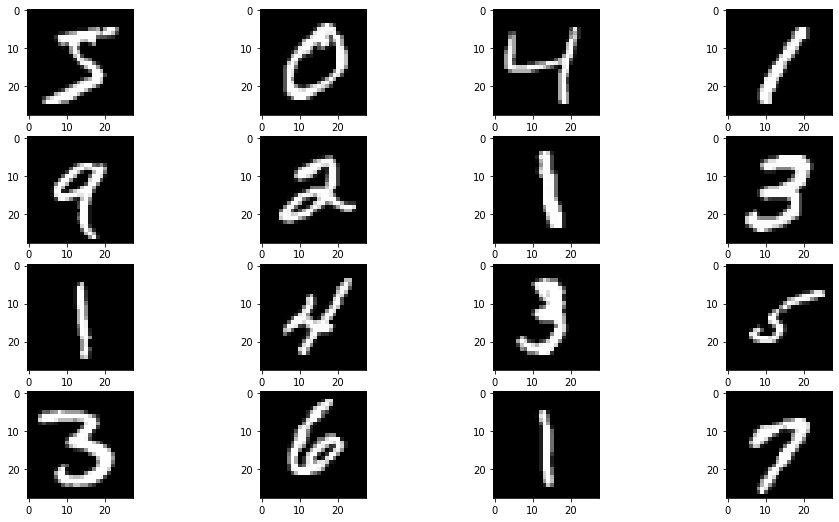

In [11]:
#
# Display some examples of the data
#
for i in range(16):
    plt.subplot(4,4,1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [12]:
#
# Display labels of some data
#
for i in range(15):
    print('label {}'.format(y_train[i]))

label 5
label 0
label 4
label 1
label 9
label 2
label 1
label 3
label 1
label 4
label 3
label 5
label 3
label 6
label 1


# Task: Plot a histogram of the classes of the training data (1 point)

After plotting, give a short estimation if this distribution is OK for use in a classification situation.

In [13]:
#
# Histogram of class counts (digits)
#
y_train_df = pd.DataFrame(y_train)
y_train_df = y_train_df[0].value_counts()
y_train_df.iplot(kind='bar',barmode='stack', title='Verteilung der Ausprägungen in y_train')

In [14]:
y_train_df = pd.DataFrame(y_train)
print("Relative Verteilung der Klassen innerhalb der Train-Data")
yTrainRel = ((y_train_df.value_counts(normalize=True) * 100).sort_index())
print(yTrainRel)

Relative Verteilung der Klassen innerhalb der TEST-Data
0     9.871667
1    11.236667
2     9.930000
3    10.218333
4     9.736667
5     9.035000
6     9.863333
7    10.441667
8     9.751667
9     9.915000
dtype: float64


In [15]:
y_test_df = pd.DataFrame(y_test)
y_test_df = y_test_df[0].value_counts()
y_test_df.iplot(kind='bar',barmode='stack', title='Verteilung der Ausprägungen in y_test')

In [16]:
y_test_df = pd.DataFrame(y_test)
#print("Relative Verteilung der Klassen innerhalb der TEST-Data")
#print((y_test_df.value_counts(normalize=True) * 100).sort_index())
yTestRel = ((y_test_df.value_counts(normalize=True) * 100).sort_index())

In [17]:
dfRelativeVerteilung = pd.DataFrame()
dfRelativeVerteilung['TrainData-Rel'] = yTrainRel
dfRelativeVerteilung['TestData-Rel'] = yTestRel
dfRelativeVerteilung['REL-Diff'] = yTrainRel - yTestRel

display(dfRelativeVerteilung)

,TrainData-Rel,TestData-Rel,REL-Diff
0,,,
0,9.871667,9.80,0.071667
1,11.236667,11.35,-0.113333
2,9.930000,10.32,-0.390000
3,10.218333,10.10,0.118333
4,9.736667,9.82,-0.083333
5,9.035000,8.92,0.115000
6,9.863333,9.58,0.283333
7,10.441667,10.28,0.161667
8,9.751667,9.74,0.011667


Ich hätte das Dataset sowohl in Train als auch in Test "gleichverteilter" erwartet. 
Dennoch sind in allen Feature ("0"-"9") ausreichend Ausprägungen vorhanden, sodass eine Klassifikation möglich ist. Damit ist gemeint man kann ausreichend große Train / Test (hier keine Validation) Datasets hat. 

Ausserdem ist hervorzuheben dass sowohl in Train als auch Test die relative Ausprägung der unterschiedlichen Klassen inetwa gleich ist. Sprich Sowohl in TRAIN als auch in TEST sind am wenigsten "5er" Klassen/Ausprägungen und am häufigsten Ausprägungen der Klasse 1 anzutreffen.(Spoiler: Diesen Unterschied an der Anzahl der jeweiligen Input-Klassen werden wir später auch in der Prediction Quality sehen. Sprich die Klasse 5 wird später häufiger "falsch(=als eine andere Klasse)" predictet.

Vergleichen wir nun die relative Ausprägung über die Datensätze hinweg so sind die Maximalwerte -0.39%(Klasse2), und 0,11833%(Klasse3). Ziel wäre es die relative Ausprägung einer Klasse sowohl in train als auch in Testdata gleich zu haben um auf einem möglichst genauen Abbild der Realität die Modelle zutrainieren. Hier ist die Abweichung je klasse unter 0.5%  == (0.005). Mit meiner Einschätzung sollte dies zu keiner Verfälschung führen.

Auch wenn die Implementierung von Plotly über den Umweg der Umwandlung in Pandas Framweworks "ziemlich" umständlich ist, rentiert sich die Mühe dennoch. Durch die Interaktionsoption lässt sich "schön" mit den Grafiken interagieren.

# Prepare data for classification

In [18]:
# 
# Change shape of data for model
#
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [19]:
# 
# Scale pixel values into range of 0 to 1
#
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [20]:
# 
# One-hot encoding for classes
#
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# reverse 

In [21]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Build the first model

In [22]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
modelSimpleBasic = create_model()

In [24]:
history = modelSimpleBasic.fit(x_train, y_train, batch_size=128, epochs=5 )

Epoch 1/5
469/469 [==============================] - 28s 60ms/step - loss: 0.2008 - accuracy: 0.9398
Epoch 2/5
469/469 [==============================] - 25s 54ms/step - loss: 0.0666 - accuracy: 0.9797
Epoch 3/5
469/469 [==============================] - 27s 57ms/step - loss: 0.0433 - accuracy: 0.9869
Epoch 4/5
469/469 [==============================] - 25s 54ms/step - loss: 0.0301 - accuracy: 0.9906
Epoch 5/5
469/469 [==============================] - 25s 52ms/step - loss: 0.0229 - accuracy: 0.9926


In [25]:
# save model to JSON

In [26]:
modelSimpleBasic.predict(x_train[:1])

array([[1.2218548e-10, 1.0382464e-08, 1.1825452e-09, 8.3146263e-03,
        5.0840242e-11, 9.9168491e-01, 9.6382374e-11, 4.0216599e-09,
        2.3167071e-07, 2.0650565e-07]], dtype=float32)

In [27]:
y_train[:1]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [28]:
#
# Measure the accuracy
#
_, acc = modelSimpleBasic.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98360


In [29]:
#
# Estimate the number of false classifications in production use
#
print('with {} samples there are about {:.0f} false classifications to expect.'.format( x_test.shape[0], (x_test.shape[0]*(1-acc))))

with 10000 samples there are about 164 false classifications to expect.


# Print out training

In [30]:
#
# Plot loss and accuracy
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

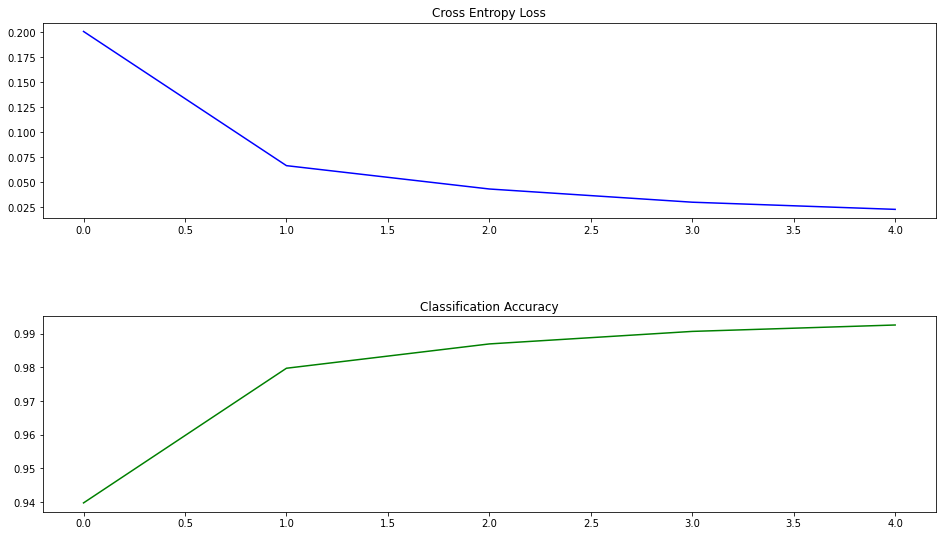

In [31]:
summarize_diagnostics(history,'model-Basic')

# Task: Repeat the training until you see overfitting (2 points)

Change the training parameter (epochs) of the simple model until you see overfitting. Dokument the number of epochs from which on you see overfitting.

**Note** make sure to restart training from epoch 0 and not to continue training of the model.

**Overfitting** = Jener Punkt(Anzahl an Epochen) in welchem nur noch der Training Error fällt&Training accuracy steigt/"stagniert", hierbei werden auf dem Validation(oder eben Testset) keine weiteren Verbesserungen mehr erzielt.

**Version-1**<br> Wiederholen des bisherigen Neuronalen Netzes mit mehreren Epochen & Zeitgleich wird hier noch das Validation hinzugefügt um das Overfitting aufdecken zu können.

Um nun die Anzahl der Epochen zu detektieren lasse ich zunächst oberes modell mit bis zu 20 Epochen laufen. Die dabei entstehenden Train Accuracy & Train Error vergleiche ich mit den Test Accuracy & Test Error der jeweiligen Epoche. Im nächten Schritt wird dann ein Early-Stopping implementiert.

Zunächst muss das Model jedoch neu initalisiert werdne. Dazu rufe ich einfach nochmals die eingehende "Modell-Erstellungs-Funktion" auf.

Overfitting(~auswendig lernen) findet dann statt, wenn der Train-Accuracy weiter steigt, während die Test-Accuracy bereits stagniert bzw bereits sich verringert, Das kann man einfach visualiseren indem man zu jeder Epoche sowohl die Train als auch die Test-Accuracy plotet. Overfitting bedeutet, dass das Modell den zugrunde liegenden Trend(der Trainingsdaten) zu eng an den Fehler oder dem  Rauschen anpasst.

![image.png](./imgs/Overfitting.png)

Veranschaulicht an oberer Grafik versuchen wir das Optimum(Minumum des TEST-Fehlers) in der Test-Accuracy zu finden. Aus diesem Grund Implementieren wir in der Version2 [Early-Stopping](https://github.com/JHC90/Basic-DataScience-Skills/wiki/0_EarlyStopping) . Hierbei wird das Modell solange trainiert, bis keine weitere Reduktion der Test-Accuracy (~besser gesagt ein Schwellwert an "mindest performance-Schub" nicht mehr über/unterschritten wird) erzielt wird. Dann bricht das Modell ab = Early Stopping.

Zuvor betrachten wir jedoch die Performance eines Modelles ohne eien Early-Stopping Implementierug und lassen das Modell über 20 Epochen laufen.

In [32]:
# Neues Modell ohne ES initialisieren
modelSimpleBasic_DemoOverfitting = create_model()

In [33]:
# Hier lasse ich insgesammt 20 Epochen laufen. Ich erhoffe mir als Insight in den anschließdendem Diagrammen
# "optische wahrzunehmen" ab welcher Epochenzahl das Overfitting anzutreffen ist
history2 = modelSimpleBasic_DemoOverfitting.fit(x_train, y_train, 
                    batch_size=128, 
                    epochs=20,
                    validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 26s 55ms/step - loss: 0.1802 - accuracy: 0.9459 - val_loss: 0.0757 - val_accuracy: 0.9758
Epoch 2/20
469/469 [==============================] - 26s 56ms/step - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.0614 - val_accuracy: 0.9799
Epoch 3/20
469/469 [==============================] - 26s 56ms/step - loss: 0.0399 - accuracy: 0.9880 - val_loss: 0.0550 - val_accuracy: 0.9823
Epoch 4/20
469/469 [==============================] - 26s 56ms/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.0473 - val_accuracy: 0.9841
Epoch 5/20
469/469 [==============================] - 27s 58ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.0450 - val_accuracy: 0.9855
Epoch 6/20
469/469 [==============================] - 27s 57ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0491 - val_accuracy: 0.9847
Epoch 7/20
469/469 [==============================] - 26s 56ms/step - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.0444 - val_accuracy:

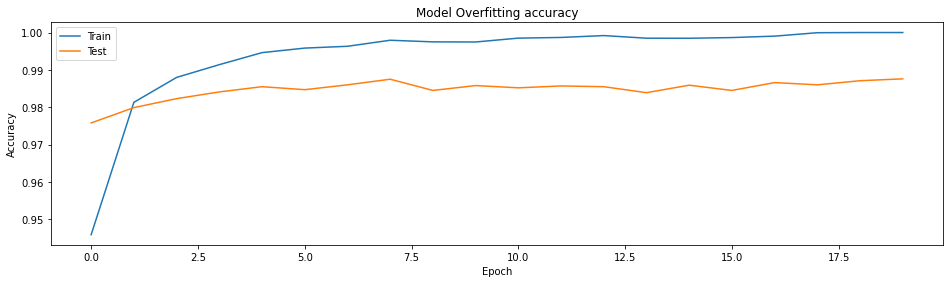

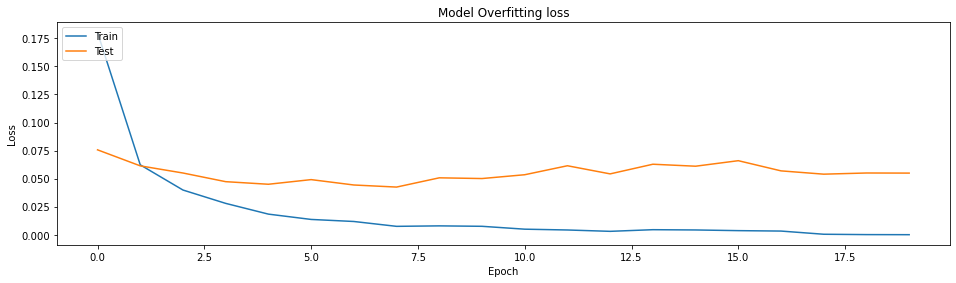

In [34]:
print_analysis_diagramm(history2)

Betrachten wir obere Grafik, so ust zu erkennen, dass die Testaccuracy bereits ab ca epoche 3 sich nicht merklich erhöht, wohingegen die der Testloss ab Epoche 8/9 sich nicht mehr "übertrieben" verringert. Das charakteristische Overfitten(Testaccuracyy fällt ab einer gewissen Epochenzahl && Test Loss steigt ab einer gewissen Epochenzahl), ist hier zwar "marginal" aber nicht "merklich" optisch zu erkennen. Jedoch sind die Performance-Schübe nicht zwingend so hoch pro weiterer trainierter Epoche, sodass scih ein weitere trainieren merklich rentiert.

In [35]:
_, acc = modelSimpleBasic_DemoOverfitting.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98760


# Early Stopping 
Aus der oberen Grafik ist "visuell" zu entnehmen dass das Training ab Epoche 2-3(hinsichtlich der Accuracy) bzw epoche 7-8(hinsichtlich des Losses) bereits abgeborchen werden könnte. Bzgl des Overfittings ist keine Verschlechterung der Modell performance durch eine höhere Epochenanzahl zu erkennen. Dies kannauch daran liegen,dass mit 20 Epochen "noch nicht" der Schwellwert hinsichtlich des Eintretens von Overfitting überschritten wurde.

D.h die nachfolgenden 17-18/12-13 Epochen wurde sinnlos trainiert und haben "nur" Rechenkapazitäten verschleudert. Um diesem "Overfitting/sinnloser Ressourcenbelegung" entgegen zu wirken hat Keras eine Logik implementiert welche das Training abbricht, sofern keine Verbesserungen innerhalb eines gewissen Zeitspanne(=Epoche) um mindesten einen definierten Schwellwert stattfindt.

Bei der Implementierung von Early-Stopping bin ich  nach diesem [Vorbild](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) vor gegangen.

In [37]:
modelSimpleBasic_DemoEarlyStopping = create_model()

In [38]:
# Early-Stoping-Condition
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=1, patience=5)
# Model Checkpoint Condition
mc = ModelCheckpoint('./Modelle/ES-best_model.h5', monitor='val_loss', mode='min', verbose=1)

In [39]:
history3 = modelSimpleBasic_DemoEarlyStopping.fit(x_train, y_train, 
                    batch_size=128, 
                    epochs=20,
                    validation_data=(x_test, y_test), 
                    callbacks=[es, mc])

Epoch 1/20
468/469 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9487
Epoch 00001: saving model to ./Modelle\ES-best_model.h5
469/469 [==============================] - 27s 57ms/step - loss: 0.1690 - accuracy: 0.9487 - val_loss: 0.0717 - val_accuracy: 0.9788
Epoch 2/20
468/469 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9844
Epoch 00002: saving model to ./Modelle\ES-best_model.h5
469/469 [==============================] - 26s 56ms/step - loss: 0.0539 - accuracy: 0.9843 - val_loss: 0.0521 - val_accuracy: 0.9832
Epoch 3/20
468/469 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9897
Epoch 00003: saving model to ./Modelle\ES-best_model.h5
469/469 [==============================] - 26s 56ms/step - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 4/20
468/469 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9929
Epoch 00004: saving model to ./Modelle\ES-best_mo

accuracy 0.98360


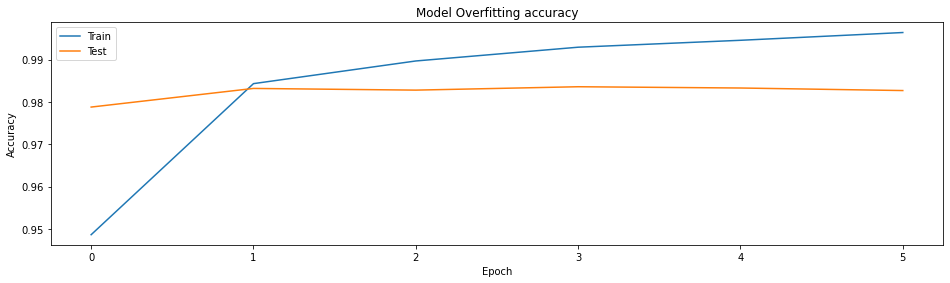

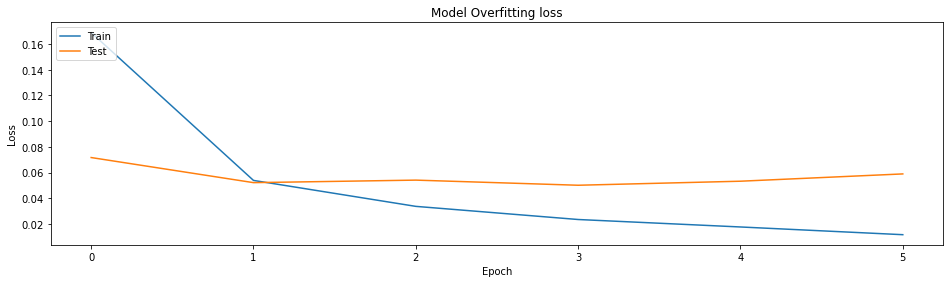

In [40]:
# Übersetzt wurde nun das 2te Modell gespeichert und in den folgenden 5 Epochen wurde keine "ausreichende" Verbesserung erzielt 
# & es wurden eben nicht die 20 möglichen Epochen durchlaufen

# Laden der bisher besten Modelles in von der ES-Implementierung
from keras.models import load_model
saved_model = load_model('./Modelle/ES-best_model.h5')
modelSimpleBasic_DemoEarlyStopping.predict(x_train[:1])
_, acc = modelSimpleBasic.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))
print_analysis_diagramm(history3)

Trotz dessen dass das Modell laut Definition 20 Epochen trainieren hätte können bricht es nach Epoch 6 das Training ab. dabei ist die Bedingung, dass von einer Epoche zur nächsten ein Verbesserung um 1% hinsichtlich der Accuracy stattfindet. Diese Verbsserung von mindestens 1% wurde in der Epoche 2 "noch" erzielt. Die nachfolgenden Epochen erzielen zwar(meist) zunehmende Accuracys, jedoch sind die individuellen "Performance Schübe" in der Test-Accuracy unter 1%. Ergo bricht das Modell nach einer definierten Zeitspanne von 5 weiteren Versuchen=Epochen das Training ab und verwendet nun das bisher beste Modell(in unserem Falle das Modell aus Epoche 5 welches eine Testaccuracy von 0.9857 hat).
 

# Task: Improve the model significantly (3 points)

Your customer requires to have less than 1% of wrong classifications. Start to build a better model with significantly less than 100 wrong classifications in the 10000 test samples. Research the internet for the optimal model setup for MNIST classification and try to replicate this model here. Make sure to document the source where you found the hints for the improvement (link).

**MNIST-Master-Solutions** gibt es zahlreiche. Ich habe die Architektur, welche ich nun weiter nutze von dieser  [Implementierung](https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1) "gestohlen". Grob ist der Unteschied, dass in dem "gestohlenen CNN-Model" u.a. mehr Layer, eine tiefere Architektur, mehr Filter, eine Batchnormalization nach dem Flatten etc auftreten. Dadurch wird das Modell komplexer und benötigt mehr Ressourcen bzw Zeit für das Training.

In [41]:
def createStolenModel():
    model2=Sequential()
    #model.add(Lambda(standardize,input_shape=(28,28,1)))    
    model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
    model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(BatchNormalization())    
    model2.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))

    model2.add(MaxPooling2D(pool_size=(2,2)))

    model2.add(Flatten())
    model2.add(BatchNormalization())
    model2.add(Dense(512,activation="relu"))

    model2.add(Dense(10,activation="softmax"))
     # compile
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
    return(model2)


In [42]:
model2 = createStolenModel()

In [43]:
#
# Save a model for later use
#
from keras.models import model_from_json

modelName="./Modelle/ES-StolenModel-FreshInitialized.json"
weightName = "./Modelle/ES-StolenModel-FreshInitialized.h5"

# Speichern des Basic untrainierten Modelles mit den randomized Gewichten 
# => wenn ich später unterschiedliche Modelle drauf laufen lasse, dann haben alle zu Beginn "die gleichen Karten"

# set to True if the model should be saved
save_model = True
if save_model:
    model_json = model2.to_json()
    with open( modelName , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model2.save_weights( weightName )
    print("saved model to disk as {} {}".format(modelName,weightName))

saved model to disk as ./Modelle/ES-StolenModel-FreshInitialized.json ./Modelle/ES-StolenModel-FreshInitialized.h5


Ich verwende auch hier von anbeginn Early-Stopping. Letzlich will ich das Model nicht weitertrainieren als wie zu den gewünschten 99%. Ich nehm ganz genau 99,5 % es soll ja signifikant besser sein....bei noch besseren Ergebnissen einfach an der Zahl drehen & Vorsicht dass man nicht zu sehr in overfitting rutscht.

In [44]:
es = EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.9925, patience=5)
mc = ModelCheckpoint('./ES-best_StolenModel_ES99.h5', monitor='val_accuracy', mode='max', verbose=1)

# train with history
historyStolenModel = model2.fit(x_train, y_train, 
                                batch_size=64, 
                                epochs=20,
                                validation_data=(x_test, y_test),
                                callbacks=[es, mc])

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9735
Epoch 00001: saving model to .\ES-best_StolenModel_ES99.h5
938/938 [==============================] - 477s 508ms/step - loss: 0.0863 - accuracy: 0.9735 - val_loss: 0.0519 - val_accuracy: 0.9848
Epoch 2/20
938/938 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9883
Epoch 00002: saving model to .\ES-best_StolenModel_ES99.h5
938/938 [==============================] - 433s 462ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0273 - val_accuracy: 0.9911
Epoch 3/20
938/938 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9914
Epoch 00003: saving model to .\ES-best_StolenModel_ES99.h5
938/938 [==============================] - 434s 462ms/step - loss: 0.0273 - accuracy: 0.9914 - val_loss: 0.0449 - val_accuracy: 0.9894
Epoch 4/20
938/938 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9926
Epoch 00004: saving model to .\ES-

accuracy 0.99190


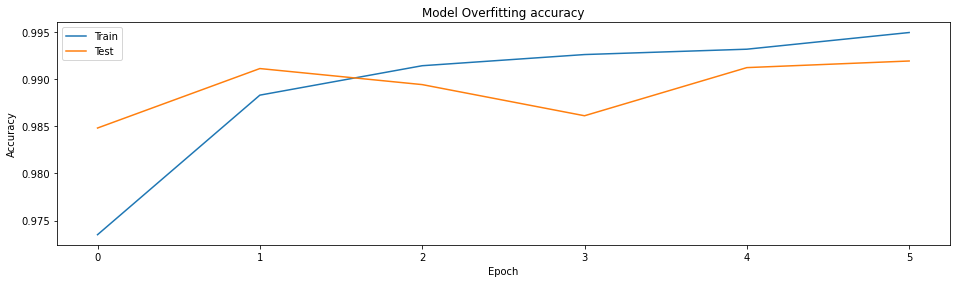

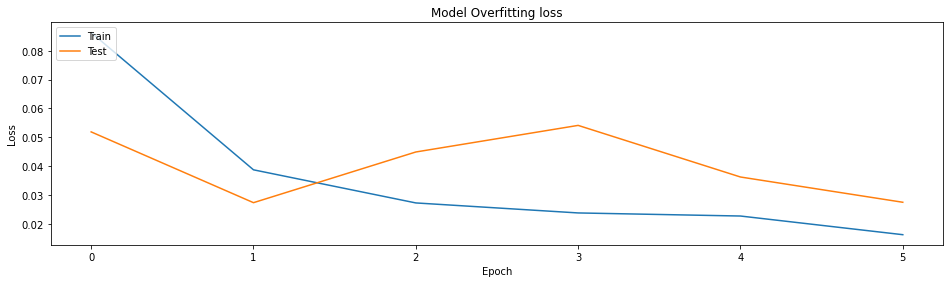

In [46]:
# Laden der bisher besten Modelles in von der ES-Implementierung des gestohlenen MOdelles
from keras.models import load_model
saved_model = load_model('./ES-best_StolenModel_ES99.h5')
saved_model.predict(x_train[:1])
_, acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))
print_analysis_diagramm(historyStolenModel)

# Benchmark

Hier lasse ich das "gestohlene" Modell  über 10 Epochen OHNE ES laufen, sodass ich Vergleichswerte erhalte. Das macht an sich keinen Sinn, da ES ja genau dieses "sinnlose" trainieren verhindern soll. Ich mache dies an dieser stelle lediglich um aufzudecken wie das Modell eben ohne ES Trainiert, und wie geringfügig der "Mehrwert" im Vergleich zu den verbrauchten Ressourcen ist.

In [47]:
# load model (has to be saved before, is not part of git)   
# laden des untrainierten Modell mit den gleichen initilaen Randomized weights, wie es bereits das ES-Modell hatte
modelName="./Modelle/ES-StolenModel-FreshInitialized.json"
weightName = "./Modelle/ES-StolenModel-FreshInitialized.h5"


save_model = False
if not save_model:
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weightName)
    print("loaded model from disk")

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

loaded model from disk


In [48]:
historyStolenModelEpochsBenchmark = loaded_model.fit(x_train, y_train, 
                                batch_size=64, 
                                epochs=10,
                                validation_data=(x_test, y_test)
                                )

Epoch 1/10
938/938 [==============================] - 436s 464ms/step - loss: 0.0856 - accuracy: 0.9730 - val_loss: 0.0495 - val_accuracy: 0.9850
Epoch 2/10
938/938 [==============================] - 434s 462ms/step - loss: 0.0370 - accuracy: 0.9889 - val_loss: 0.0294 - val_accuracy: 0.9899
Epoch 3/10
938/938 [==============================] - 434s 463ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.0343 - val_accuracy: 0.9889
Epoch 4/10
938/938 [==============================] - 437s 466ms/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0299 - val_accuracy: 0.9913
Epoch 5/10
938/938 [==============================] - 437s 466ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0727 - val_accuracy: 0.9806
Epoch 6/10
938/938 [==============================] - 434s 463ms/step - loss: 0.0188 - accuracy: 0.9943 - val_loss: 0.0417 - val_accuracy: 0.9884
Epoch 7/10
938/938 [==============================] - 433s 461ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0461 -

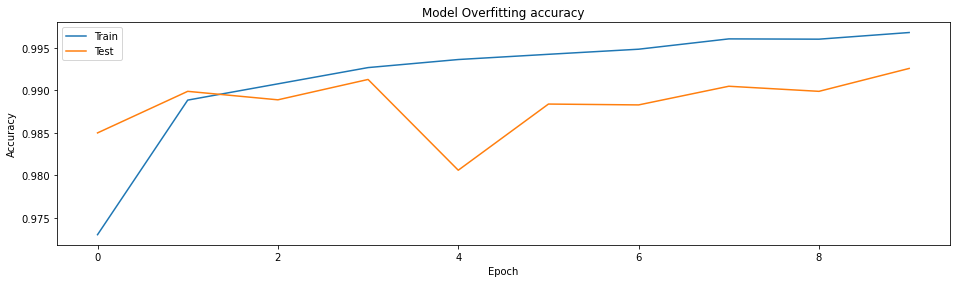

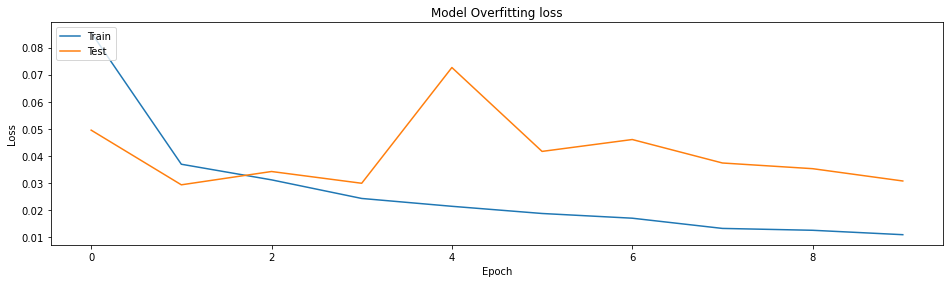

In [49]:
print_analysis_diagramm(historyStolenModelEpochsBenchmark)

In [50]:
#
# Measure the accuracy
#
_, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy {:.5f}'.format(acc))

Accuracy 0.99260


Vergleichen wir Die Modelle mit ES und ohne ES gemessen an der Test -Accuracy.
Für das Modell MIT ES erhalten wir eine Testaccuracy von 0.99190 und für Das Modell OHNE erhalten wir eine Testaccury von  0.99260. Ob die längere Rechenzeit des Modelles OHNE ES hierbei sich "rentiert" ist mit dem Kunden zu besprechen.

Zusammenfassend performt das obere "getohlene Modell mit &ohne ES Implementierung" erheblich besser als das initiale "Basic-Modell". Jedoch Frage ich mich inwiefern diese Darstellung "realisitisch" ist. MNIST it ein bekanntes Dataset, zu welchem zahlreiche performante Muster-Lösungen öffentlich exisiteren. Wäre dies ein DS-"Hello-World"-Projekt hätte man für das Finden einer passenden Architektur entsprechend 

In [51]:
#
# Estimate the number of false classifications in production use
#
print('with {} samples there are about {:.0f} false classifications to expect.'.format( x_test.shape[0], (x_test.shape[0]*(1-acc))))

with 10000 samples there are about 74 false classifications to expect.


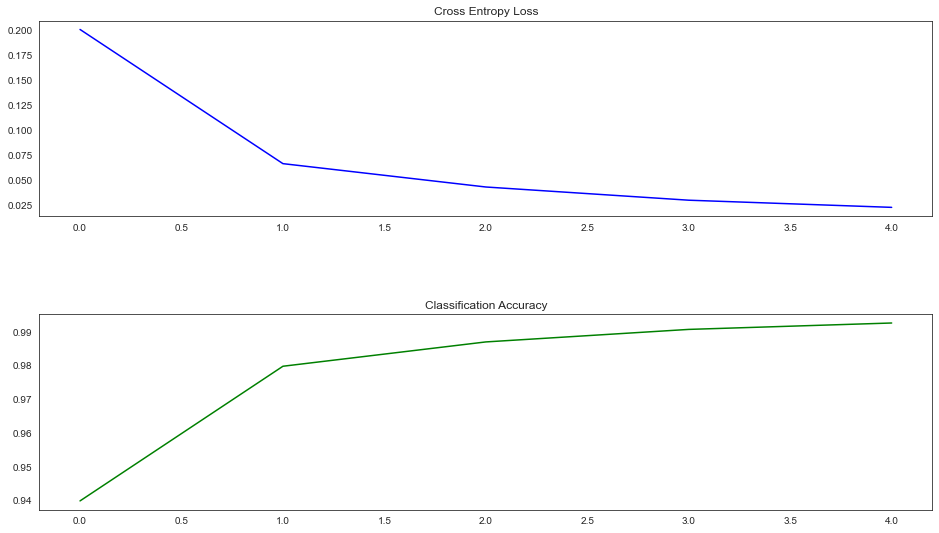

In [82]:
summarize_diagnostics(history,'01_model2')
#summarize_diagnostics(history, loaded_model)


# Save the model

In [53]:
#
# Save a model for later use

prefix = 'results/01_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

# set to True if the model should be saved
save_model = True
if save_model:
    model_json = model2.to_json()
    with open( modelName , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model2.save_weights( weightName )
    print("saved model to disk as {} {}".format(modelName,weightName))

saved model to disk as results/01_model.json results/01_model.h5


# Task: Find characteristics in the errors of the model (2 points)

There are still too many false classifications using the model. Evaluate all test data and plot examples of failed classifications to get a better undestanding what goes wrong. Plot also the count of false classifications per class. Select one class of digits that you want to improve. You can also plot a confusion matrix to get a better insight.

**Note**: Be aware that this type of debugging may create a bias which may seamingly increase the quality of the model in relation to the test data. But compared to the distribution of the real-world data the quality of the model can still be insufficient. We will handle this topic in the lecture. 

In [54]:
prefix = 'results/01_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

In [55]:
# Load the Model, hier laden, da ich während der Entwicklung nicht alles in einem Atemzug runter geskriptet habe. Mit dem Laden des
# Trainierten Modelles kann ich mir den Großteil der oberen Ausführungen sparen
json_file = open(modelName, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weightName)
print("loaded model from disk")

loaded model from disk


In [56]:
#
# Plot 9 examples of digits which where classified wrong (also show true vs wrong class)
#


In [57]:
testErrorsIndexes = []
predictedValues = []
realValues = []
for i in range(0,len(x_test),1):
    predictedValues.append(int(np.argmax(loaded_model.predict(x_test[i:i+1]))))
    realValues.append(int(np.argmax(y_test[i])))
    if(i%2500 == 0):
        print(i)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("Länge der Fehlerliste: " +str(len(testErrorsIndexes)))
        print('#########################################')
    if(int(np.argmax(loaded_model.predict(x_test[i:i+1]))) != int(np.argmax(y_test[i]))):
        testErrorsIndexes.append(i)

0
Current Time = 23:44:06
Länge der Fehlerliste: 0
#########################################
2500
Current Time = 23:56:31
Länge der Fehlerliste: 34
#########################################
5000
Current Time = 00:07:48
Länge der Fehlerliste: 56
#########################################
7500
Current Time = 00:18:11
Länge der Fehlerliste: 65
#########################################


In [58]:
# store to Drive
f=open('./Modelle/predictedValues.txt','w')
for ele in predictedValues:
    f.write(str(ele) + "\n")
f.close()

f=open('./Modelle/realValues.txt','w')
for ele in realValues:
    f.write(str(ele) + "\n")
f.close()

f=open('./Modelle/testErrorsIndexes.txt','w')
for ele in testErrorsIndexes:
    f.write(str(ele) + "\n")
f.close()

In [59]:
def readListFromFile(fileWithPath):
    #print(fileWithPath)
    currentList = []
    with open(fileWithPath, 'r') as filehandle:
        filecontents = filehandle.readlines()
        for line in filecontents:
            current_place = line[:-1]
            currentList.append(int(current_place))
    return(currentList)
predictedValues = readListFromFile('./Modelle/predictedValues.txt')
#print(predictedValues2)
realValues = readListFromFile('./Modelle/realValues.txt')
#print(realValues2)
testErrorsIndexes = readListFromFile('./Modelle/testErrorsIndexes.txt')

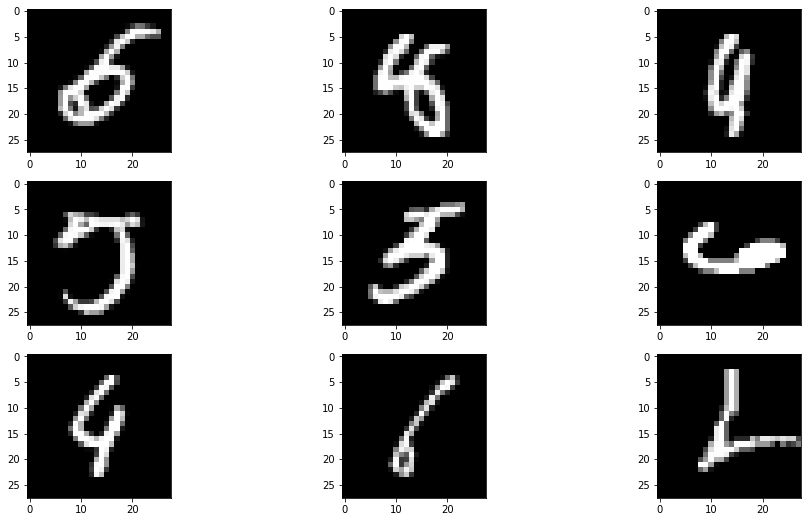

Von Links nach Rechts und von Oben Nach Unten: 
######################################
Wahre Zahl ist: 5		 ||		  in der CFM die Spalte  
Vorhergesagte Zahl: 6		 ||		  in der CFM die Zeile  
#############################################################################
Wahre Zahl ist: 8		 ||		  in der CFM die Spalte  
Vorhergesagte Zahl: 4		 ||		  in der CFM die Zeile  
#############################################################################
Wahre Zahl ist: 9		 ||		  in der CFM die Spalte  
Vorhergesagte Zahl: 4		 ||		  in der CFM die Zeile  
#############################################################################
Wahre Zahl ist: 5		 ||		  in der CFM die Spalte  
Vorhergesagte Zahl: 7		 ||		  in der CFM die Zeile  
#############################################################################
Wahre Zahl ist: 5		 ||		  in der CFM die Spalte  
Vorhergesagte Zahl: 3		 ||		  in der CFM die Zeile  
#############################################################################
Wahre Za

In [60]:
# Jedes mal andere Fehlerhafte Bilder anzeigen via random shuffle der Fehlerliste
random.shuffle(testErrorsIndexes) 
returnText= "Von Links nach Rechts und von Oben Nach Unten: \n######################################\n"
for i in range(9):
    plt.subplot(3,3,1 + i)
   
    
   
    plt.imshow(x_test[testErrorsIndexes[i]], cmap=plt.get_cmap('gray'))
    
    
    returnText = returnText +("Wahre Zahl ist: "+str(np.argmax(y_test[testErrorsIndexes[i]]))+str("\t\t ||\t\t  in der CFM die Spalte  \n"))
    returnText = returnText +("Vorhergesagte Zahl: "+str(np.argmax(loaded_model.predict(x_test[testErrorsIndexes[i]:testErrorsIndexes[i]+1]))) +str("\t\t ||\t\t  in der CFM die Zeile  \n"))
   
    returnText = returnText +("#############################################################################\n")
plt.show()
print(returnText)

<AxesSubplot:xlabel='Real-Value', ylabel='Predicted-Value'>

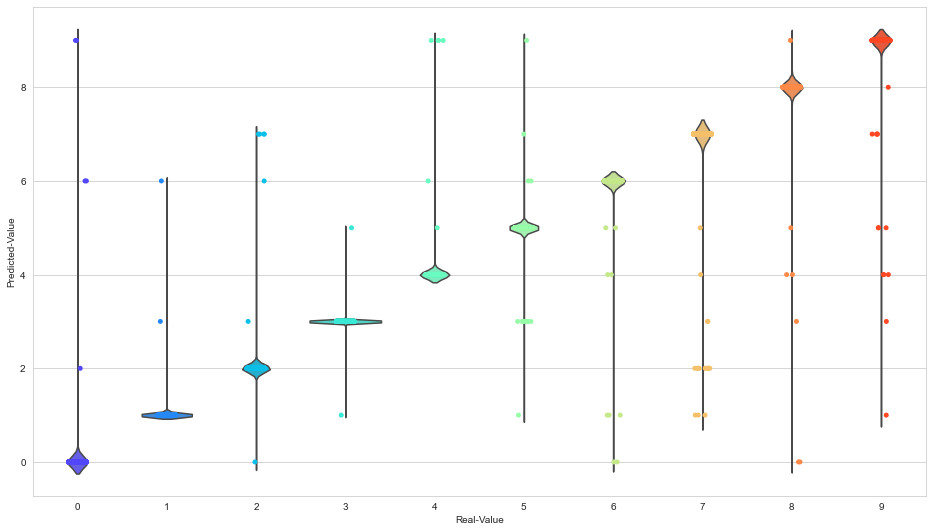

In [61]:
#
# Plot distribution of errors per class (digit)
# Das mach mit SNS und einem Violinplot
# create pandas df
DfRealVSPredicted = pd.DataFrame()
DfRealVSPredicted['Real-Value'] = realValues
DfRealVSPredicted['Predicted-Value'] = predictedValues
sns.set_style("whitegrid")
sns.violinplot(x="Real-Value", y="Predicted-Value", data=DfRealVSPredicted, palette="rainbow")
#sns.swarmplot(x="Real-Value", y="Predicted-Value", data=DfRealVSPredicted, color='black',size=3)
#sns.boxplot(x="Real-Value", y="Predicted-Value", data=DfRealVSPredicted, palette="rainbow")
sns.stripplot(x="Real-Value", y="Predicted-Value", data=DfRealVSPredicted, palette="rainbow")



Betrachten wir obere Grafik, die Kombination aus Viloin und Stripplot. Als erstes erkennt man am Bauch der Violion je KLasse dass, die überweigende Vorhersage einer Klasse grundsätzlich die Klasse selbst ist. Das ist soweit schon mal gut :-) . Betrachten wir nun die Infomration des Strip-Plots, so können wir hier ablesen wie "wiggly" die Vorhersagen sind. Am Beispiel der Abszisse(=Real-Value=X-Achse) = 3, dass eine wahre 3 :
1. überwiegend als Klasse 3 klassifiziert wird => Abzulesen am Bauch der Violine
2. 1x als eine Klasse 5 klassifiziert wird
3. 1x als eine Klasse 1 klassifizert wird

Dieses Insight lässt sich auch an folgender Confusion Matrix ablesen:

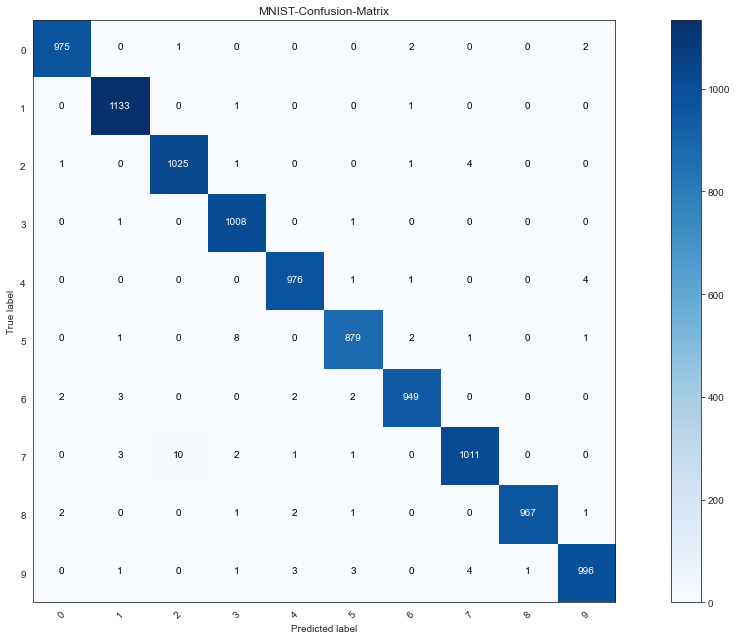

In [62]:
#
# Bonus: plot confusion matrix for test data
#
predicted = predictedValues
actual = realValues
sns.set_style("white")
cnf_matrix = confusion_matrix(actual, predicted)
labels = ["0","1","2","3","4","5","6","7","8","9"]
plot_confusion_matrix(cnf_matrix, classes=labels, title="MNIST-Confusion-Matrix")

**Result: (which digit did you select for improvement)**

Betrachten wir die beiden Grafiken aus dem Violin/Swarm/Strip-Plot sowie die Confusion Matrix so erkennt man folgende Fehler:

1) eine Wahre 5 wird 8 mal als eine 3 predicted
2) eine wahre 4 wird 4 mal als eine 9 predicted

ich konzentriere mich auf eben diese beiden Verbesserungen.

Bei der 5 & 3 werde ich mehr Trainingsdaten hinzufügen,
Bei der 4 & 9 füge ich augumentation hinzu

Anmerkung:
Eine wahre 7 wird insgesamt 10 mal als eine 2 predicted. Mit der hier erstellten Confusion Matrix hätte ich mich auf dieses Wertepaar fokusiert. Die hier erstelle CFM ist das Resultat einer Verbesserung zu dem zugehörigen Modell. Dieser Verbesserung wiederum wurde implementiert nachdem ich die "Verbesserung für 5&3 && 4&9" implementiert hatte. 

Das gesamte Notebook hier ist das Resultat eines "einzigen" Runs (Button Restart the notebook and run all Cells). Um die Verbesserung der 7&1 Werte würde ich nach jetzigem Status mehr von diesen Daten in die Trainingsdaten aufnehmen(siehe Update your Training Strategy; Solution1)(Füge nach der Funktion "def addContent()" den Aufruf mit addContent(1, 200) && addContent(7, 200)) hinzu. 

# Task: Update your training strategy (2 points)

Beside many other options, there are two possible ways to improve your model:

1. Add more data for those classes which are poorely classified
1. Add augmentation for the training data

Select **one** of the two strategies and implement it. Test if there is an improvement.

## More training data

Find the EMNIST dataset in the internet and load 200 examples of the digit with the most errors (from last task).
If you have used the confusion matrix, select also digits from the other class (where the most wrong digits from the selected class landed).
Extend the current training set with those images and labels and retrain your model.
Document the resulting accuracy.


## Augmentation

Search the internet for the ImageDataGenerator class of the Keras framework and implement such a generator for the training of the model. Select suitable augmentation which fits to the use-case. 
Document the resulting accuracy.



# Lösung 1- Mehr Daten

In [63]:
imagesEMNIST, labelsEMNIST = extract_training_samples('digits')
print('training data: X=%s, y=%s' % (imagesEMNIST.shape, imagesEMNIST.shape))
print('test     data: X=%s, y=%s' % (labelsEMNIST.shape, labelsEMNIST.shape))
print(type(imagesEMNIST))
print(type(labelsEMNIST))

training data: X=(240000, 28, 28), y=(240000, 28, 28)
test     data: X=(240000,), y=(240000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [64]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('training data: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))
print(type(x_train))
print(type(y_train))

training data: X=(60000, 28, 28), y=(60000,)
test     data: X=(10000, 28, 28), y=(10000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [65]:
#print(labelsEMNIST[0])

y_trainLIST=list(y_train)
x_trainLIST=list(x_train)
imagesEMNISTList=list(imagesEMNIST)
labelsEMNISTList=list(labelsEMNIST)


'''print(len(y_trainLIST))
print(len(x_trainLIST))

i = 0
print(y_trainLIST[i])
print(labelsEMNISTList[i])
print(x_trainLIST[i])
print(imagesEMNISTList[i])
'''

def addContent(incomoningNumber, instances2BeAdded):
    abbruchCounter = 0 
    
    for i in range(0, len(labelsEMNISTList),1):
        if(labelsEMNISTList[i] == incomoningNumber):
            y_trainLIST.append(labelsEMNISTList[i])
            x_trainLIST.append(imagesEMNISTList[i])
            abbruchCounter  = abbruchCounter +1
        if(abbruchCounter == instances2BeAdded):
            break
addContent(3, 200)
addContent(5, 200)

y_train_extended = np.array(y_trainLIST) 
x_train_extended = np.array(x_trainLIST) 



In [66]:
x_train_extended = x_train_extended.reshape((x_train_extended.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train_extended = x_train_extended.astype('float32')
x_test = x_test.astype('float32')

x_train_extended = x_train_extended / 255.0
x_test = x_test / 255.0

y_train_extended = to_categorical(y_train_extended, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print('training data: X=%s, y=%s' % (x_train_extended.shape, y_train_extended.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))

training data: X=(60400, 28, 28, 1), y=(60400, 10)
test     data: X=(10000, 28, 28, 1), y=(10000, 10)


In [67]:
# Calc Modell
model3_ExtendedData = createStolenModel()
es = EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.995)
mc = ModelCheckpoint('./Modelle/ES-best_StolenModel_ExtendedData.h5', monitor='val_loss', mode='min', verbose=1)

# train with history
historyStolenModel_Extended = model3_ExtendedData.fit(x_train_extended, y_train_extended, 
                                batch_size=64, 
                                epochs=20,
                                validation_data=(x_test, y_test),
                                callbacks=[es, mc])

Epoch 1/20
944/944 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9749
Epoch 00001: saving model to ./Modelle\ES-best_StolenModel_ExtendedData.h5
944/944 [==============================] - 721s 764ms/step - loss: 0.0829 - accuracy: 0.9749 - val_loss: 0.0408 - val_accuracy: 0.9880
Epoch 2/20
944/944 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9884
Epoch 00002: saving model to ./Modelle\ES-best_StolenModel_ExtendedData.h5
944/944 [==============================] - 481s 509ms/step - loss: 0.0382 - accuracy: 0.9884 - val_loss: 0.0361 - val_accuracy: 0.9898


In [68]:
_, acc = model3_ExtendedData.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98980


In [69]:
testErrorsIndexesExtended = []
predictedValuesExtended = []
realValuesExtended = []
for i in range(0,len(x_test),1):
    predictedValuesExtended.append(int(np.argmax(model3_ExtendedData.predict(x_test[i:i+1]))))
    realValuesExtended.append(int(np.argmax(y_test[i])))
    if(i%2500 == 0):
        print(i)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("Länge der Fehlerliste: " +str(len(testErrorsIndexesExtended)))
        print('#########################################')
    if(int(np.argmax(loaded_model.predict(x_test[i:i+1]))) != int(np.argmax(y_test[i]))):
        testErrorsIndexesExtended.append(i)
        
f=open('predictedValuesExtended.txt','w')
for ele in predictedValuesExtended:
    f.write(str(ele) + "\n")
f.close()

f=open('realValuesExtended.txt','w')
for ele in realValuesExtended:
    f.write(str(ele) + "\n")
f.close()

f=open('testErrorsIndexesExtended.txt','w')
for ele in testErrorsIndexesExtended:
    f.write(str(ele) + "\n")
f.close()

0
Current Time = 00:48:58
Länge der Fehlerliste: 0
#########################################
2500
Current Time = 00:53:17
Länge der Fehlerliste: 34
#########################################
5000
Current Time = 00:57:35
Länge der Fehlerliste: 56
#########################################
7500
Current Time = 01:01:53
Länge der Fehlerliste: 65
#########################################


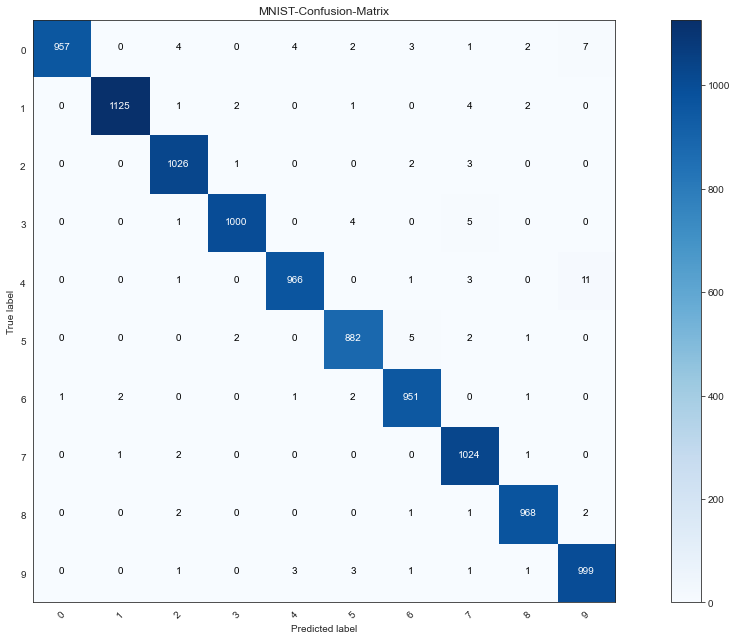

In [70]:
predicted = predictedValuesExtended
actual = realValuesExtended
sns.set_style("white")
cnf_matrix = confusion_matrix(actual, predicted)
labels = ["0","1","2","3","4","5","6","7","8","9"]
plot_confusion_matrix(cnf_matrix, classes=labels, title="MNIST-Confusion-Matrix")

Durch das hinzufügen weiterer (3er & 5er Image-)Daten haben wir bei den wahren 5er die fälschlicherweis als 3 klassifizierten auf eine Anzahl von ursprünlgich 8(Modell ohne extended Data) auf eine Anzahl von 2(Model mit extended Data) verringern können.

# # Lösung 2- Data-Augumentation
Die Augumenataion nehme ich nach folgendem [Vorbild](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) vor.

https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

In [71]:
# Laden des MNSIT-Data-Sets, da ich einen unverfäälschen Vergleich zu den anderen Modellen haben möchte 
# => das extended Dataset muss somit mit den ursprünglichen Daten überschrieben werden
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('training data: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))


x_train_Augumenation = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train_Augumenation = x_train_Augumenation.astype('float32')
x_test = x_test.astype('float32')

x_train_Augumenation = x_train_Augumenation / 255.0
x_test = x_test / 255.0

y_train_Augumenation = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print('training data: X=%s, y=%s' % (x_train_Augumenation.shape, y_train_extended.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))

training data: X=(60000, 28, 28), y=(60000,)
test     data: X=(10000, 28, 28), y=(10000,)
training data: X=(60000, 28, 28, 1), y=(60400, 10)
test     data: X=(10000, 28, 28, 1), y=(10000, 10)


In [72]:
from keras.preprocessing.image import ImageDataGenerator
# applying transformation to image = Data Augumentation
train_gen = ImageDataGenerator(rotation_range=8, 
                               width_shift_range=0.08, 
                               shear_range=0.3, 
                               height_shift_range=0.08, 
                               zoom_range=0.08 )
test_gen = ImageDataGenerator()

In [73]:
training_set= train_gen.flow(x_train_Augumenation, y_train_Augumenation, batch_size=64)
test_set= train_gen.flow(x_test, y_test, batch_size=64)

In [74]:
model4_Augumentation = createStolenModel()
es = EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.995)
mc = ModelCheckpoint('./Modelle/ES-best_StolenModel_ExtendedData.h5', monitor='val_loss', mode='min', verbose=1)

# train with history
historyStolenModel_Augumentation = model4_Augumentation.fit_generator(training_set,
                                steps_per_epoch=60000//64, 
                                validation_data=test_set,
                                validation_steps=10000//64,
                                epochs=20,
                                callbacks=[es, mc])

Epoch 1/20
937/937 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9637
Epoch 00001: saving model to ./Modelle\ES-best_StolenModel_ExtendedData.h5
937/937 [==============================] - 447s 477ms/step - loss: 0.1185 - accuracy: 0.9637 - val_loss: 0.0699 - val_accuracy: 0.9793
Epoch 2/20
937/937 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9838
Epoch 00002: saving model to ./Modelle\ES-best_StolenModel_ExtendedData.h5
937/937 [==============================] - 442s 472ms/step - loss: 0.0554 - accuracy: 0.9838 - val_loss: 0.0432 - val_accuracy: 0.9876


In [75]:
_, acc = model4_Augumentation.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98790


In [76]:
testErrorsIndexesAugumentation = []
predictedValuesAugumentation = []
realValuesAugumentation = []
for i in range(0,len(x_test),1):
    predictedValuesAugumentation.append(int(np.argmax(model4_Augumentation.predict(x_test[i:i+1]))))
    realValuesAugumentation.append(int(np.argmax(y_test[i])))
    if(i%2500 == 0):
        print(i)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("Länge der Fehlerliste: " +str(len(testErrorsIndexesAugumentation)))
        print('#########################################')
    if(int(np.argmax(loaded_model.predict(x_test[i:i+1]))) != int(np.argmax(y_test[i]))):
        testErrorsIndexesAugumentation.append(i)
        
f=open('predictedValuesAugumentation.txt','w')
for ele in predictedValuesAugumentation:
    f.write(str(ele) + "\n")
f.close()

f=open('realValuesAugumentation.txt','w')
for ele in realValuesAugumentation:
    f.write(str(ele) + "\n")
f.close()

f=open('testErrorsIndexesAugumentation.txt','w')
for ele in testErrorsIndexesAugumentation:
    f.write(str(ele) + "\n")
f.close()

0
Current Time = 01:21:23
Länge der Fehlerliste: 0
#########################################
2500
Current Time = 01:25:41
Länge der Fehlerliste: 34
#########################################
5000
Current Time = 01:30:01
Länge der Fehlerliste: 56
#########################################
7500
Current Time = 01:34:19
Länge der Fehlerliste: 65
#########################################


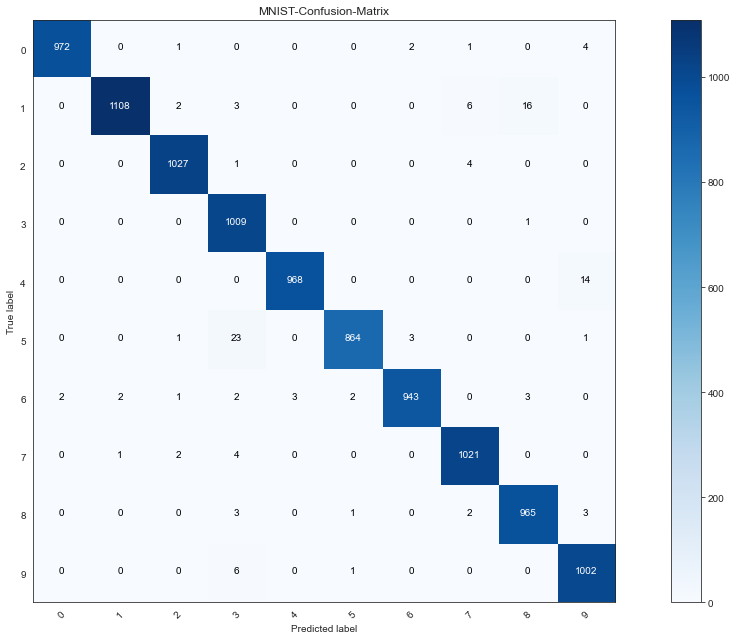

In [77]:
predicted = predictedValuesAugumentation
actual = realValuesAugumentation
sns.set_style("white")
cnf_matrix = confusion_matrix(actual, predicted)
labels = ["0","1","2","3","4","5","6","7","8","9"]
plot_confusion_matrix(cnf_matrix, classes=labels, title="MNIST-Confusion-Matrix")

Vergleichen wir nun die Data-Augumentation mit der Verbsserungsstratgie von "mehr Daten", so erzielt das Hinzufügen von Daten eine Testperformance von 0.98980 und die Data-Augumentationeine Testperformance von 0.98790. Die Ausgagns-Test-Accuracy war bei: 0.99260, somit haben die beiden Verbesserungsversuche in diesem Falle die individuellen Fehler (5&3 && 4&9) zwar verbessert, jedoch insgesamt die Performance des Modelles verringert. 

Zusammenfassend würde ich somit mit dem Modell mit der Accuracy von 0.99190(mit ES) bzw. 0.99260(ohne ES) bei dem Kunden pitchen.

In [79]:
tend = datetime.now()
print(tend)
print("Der Lauf des gesamten Notebooks dauert: " + str(tend-tstart))

2020-08-16 01:38:41.344262
Der Lauf des gesamten Notebooks dauert: 4:16:27.829717
